In [1]:
import numpy as np
from math import sqrt, exp
from matplotlib import pyplot as plt

In [2]:
def get_stages(yn, A, c, h, t, f):
    # f = function
    s = len(c) # number of stages
    m = len(yn) # number of differential equations in system
    k = np.zeros([s, m]) # initialize empty array for stages
    k[0] = f(t + c[0] * h, yn) # initial stage k1
    # Compute stages k2, k3, k4, ... 
    for i in range(1, s):
        sum_prevStages = sum([A[i][j] * k[j] for j in range(i)])
        k[i] = f(t + c[i] * h, yn + h * sum_prevStages) 
    return k

def runge_kutta_solver(yn, A, b, c, h, t, f):
    # yn = approx. sol. of prev. timepoint
    # A = spatial shift matrix
    # b = averaging weight vector of length s (s = #stages)
    # c = temporal shift vector of length s 
    s = len(c) # number of stages
    k = get_stages(yn, A, c, h, t, f)
    y_nplus1 = yn + h * sum([b[i] * k[i] for i in range(s)]) # compute approx. solution y of next time point
    return y_nplus1
    

def rk_time_stepper(y0, A, b, c, h, t0, tf, f):
    # Call the runge kutta solver for all time points
    time = np.arange(t0, tf+h, h);
    N = len(time) # total number of time steps
    y_all_timesteps = np.zeros([N, len(y0)]) # initialize empty array for solutions of all time steps
    y_all_timesteps[0] = y0 # initial condition
    for n in range(1, N):
        y_all_timesteps[n] = runge_kutta_solver(y_all_timesteps[n-1], A, b, c, h, time[n], f);
    return time, y_all_timesteps
    
    

In [3]:
def two_body_problem(t, y):
    y1, y2, y3, y4 = y
    dy1 = y3
    dy2 = y4
    dy3 = - y1 / ( (y1**2 + y2**2)**(3/2) )
    dy4 = - y2 / ( (y1**2 + y2**2)**(3/2) )
    return [dy1, dy2, dy3, dy4]

In [4]:
# Butcher table Heun's Method
A_heun = [[0, 0],[1, 0]]
b_heun = [0.5, 0.5]
c_heun = [0, 1]

In [5]:
# Initial values
y0 = [0.5, 0, 0, sqrt(3)]

# Parameters
t0 = 0
tf = 8
h1 = 0.1
h2 = 0.01

In [6]:
# Solve 2-body-problem using Heun's Method
time_h1, y_rk_h1 = rk_time_stepper(y0, A_heun, b_heun, c_heun, h1, t0, tf, two_body_problem)
time_h2, y_rk_h2 = rk_time_stepper(y0, A_heun, b_heun, c_heun, h2, t0, tf, two_body_problem)

In [7]:
y_rk_h1[0:3, :]

array([[ 0.5       ,  0.        ,  0.        ,  1.73205081],
       [ 0.48      ,  0.17320508, -0.36873414,  1.67359959],
       [ 0.42506525,  0.33404772, -0.67627167,  1.51087874]])

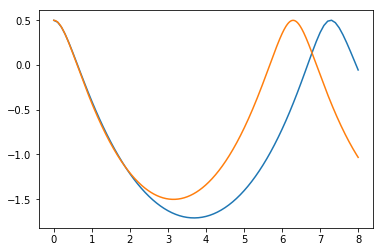

In [8]:
plt.plot(time_h1, y_rk_h1[:, 0])
plt.plot(time_h2, y_rk_h2[:, 0])

In [9]:
#Butcher Tables
A_Euler=np.array([0])
b_Euler=np.array([1])
c_Euler=np.array([0])

A_Heun=np.array([[0,0],[1,0]])
b_Heun=np.array([0.5,0.5])
c_Heun=np.array([0,1])

A_RK3=np.array([[0,0],[2.0/3,0]])
b_RK3=np.array([1.0/4,3.0/4])
c_RK3=np.array([0,2/3.0])

A_RK4=np.array([[0,0,0],[0.5,0,0],[0,0.5,0],[0,0,1]])
b_RK4=np.array([1/6.,1/3.,1/3.,1/6.])
c_RK4=np.array([0,1/2.,1/2.,1])

In [10]:
def ode(t, x):
    # M: nxn matrix, x: nx1 vector
    M = np.array([[-1001, 999],[999, -1001]])
    return M@x

In [11]:
# x0 = np.array([-1, 1])
# x0 = np.array([1, 1])
x0 = np.array([2, 0])

In [12]:
N = 1000
h = 1/N
t0 = 0
tf = t0 + N*h
# time_ode, y_rk_ode = rk_time_stepper(x0, A_Euler, b_Euler, c_Euler, h, t0, tf, ode)
time_ode, y_rk_ode = rk_time_stepper(x0, A_RK4, b_RK4, c_RK4, h, t0, tf, ode)

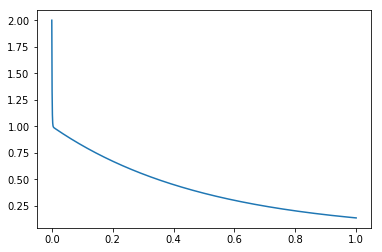

In [13]:
plt.plot(time_ode, y_rk_ode[:,0])

In [14]:
def exact_solution_ode(t, x0):
    x1 = 0.5 * (x0[0] - x0[1]) * exp(-2000 * t) + 0.5 * (x0[0] + x0[1]) * exp(-2 * t)
    x2 = 0.5 * (x0[1] - x0[0]) * exp(-2000 * t) + 0.5 * (x0[0] + x0[1]) * exp(-2 * t)
    return np.array([x1, x2])

In [15]:
x_exact = np.zeros([N+1, len(x0)])
x_exact[0] = x0
for i in range(1, N+1):
    x_exact[i] = exact_solution_ode(time_ode[i], x0)

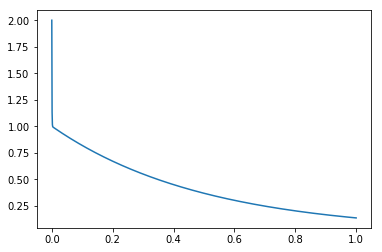

In [16]:
plt.plot(time_ode, x_exact[:,0], "-")

In [17]:
# Adaptive step size
def adaptive_step_size(x, x_hat, TOL, Fs, p, h):
    l = np.linalg.norm(np.array([x[i] - x_hat[i] for i in range(len(x))])) # local error estimator
    # if the local error is higher than the tolerance, reject x (return false) and reduce the step size h
    if l > TOL: 
        h = h * (TOL/l)**(1/(1+p)) * Fs
        return False, h
    
    # if the local error is <= tolerance, accept x (return true) and propose new, larger h for next step
    if l <= TOL:
        h = h * (TOL/l)**(1/(1+p)) * Fs
        return True, h

In [23]:
# Runge Kutta Method with dynamic step-size adaptation: Embedded Runge-Kutta method
def embedded_runge_kutta_stepper(y0, A, b, c, b_hat, h, t0, tf, f, TOL, Fs, p):

    # initialize list for solutions of all time steps for y and reference y_hat and pass initial value
    y_all_timesteps = [y0]
    y_all_timesteps_hat = [y0]
    time = [t0] # list for all the time-points computed. Will be returned.
    t = t0 # intialize time iterator with starting time t0
    i = 0
    accepted = False
    while t <= tf:
        # Compute y and y_hat for different h until they are accepted (error below tolerance)
        y = runge_kutta_solver(y_all_timesteps[i], A, b, c, h, t, f);
        y_hat = runge_kutta_solver(y_all_timesteps_hat[i], A, b_hat, c, h, t, f);
        
        accepted, h = adaptive_step_size(y, y_hat, TOL, Fs, p, h)
        
        if accepted:
            print("Iteration %d: Accepted y_n+1. New h for next iteration: %f" %(i, h))
            # if the local error of the solution is <= tolerance, accept y and y_hat and add to list
            # else repeat computation with new h
            y_all_timesteps += [y]
            y_all_timesteps_hat += [y_hat]
            t += h
            time += [t]
            i += 1 # number of time steps (iterator for accessing list for prev. solution)
            
    return time, y_all_timesteps, y_all_timesteps_hat
    

In [34]:
A_DOPRI5=np.array([[0,0,0,0,0,0,0],[1/5,0,0,0,0,0,0],[3/40,9/40,0,0,0,0,0],[44/45,-56/15,32/9,0,0,0,0],[19372/6561,-25360/2187,64448/6561,-212/729,0,0,0],[9017/3168,-355/33,46732/5247,49/176,-5103/18656,0,0],[35/384.,0,500/1113,125/192,-2187/6784,11/84,0]])
b_DOPRI5=np.array([35/384.,0,500/1113,125/192,-2187/6784,11/84,0])
b_hat_DOPRI5=np.array([5179/57600,0,7571/16695,393/640,-92097/339200,187/2100,1/40])
c_DOPRI5=np.array([0,1/5.,3/10.,4/5,8/9,1,1])

In [39]:
# SYSTEM OF ODES
# x0 = np.array([-1, 1])
# x0 = np.array([1, 1])
# x0 = np.array([2, 0])

# N = 100
# h = 1/N
# t0 = 0
# tf = t0 + N*h

# 2 BODY PROBLEM
# Initial values
x0 = [0.5, 0, 0, sqrt(3)]

# Parameters
t0 = 0
tf = 4
h = 0.1


TOL = 0.05
Fs = 0.8
p = 4
time, y, y_hat = embedded_runge_kutta_stepper(x0, A_DOPRI5, b_DOPRI5, c_DOPRI5, b_hat_DOPRI5, h, t0, tf, two_body_problem, TOL, Fs, p)

Iteration 0: Accepted y_n+1. New h for next iteration: 0.523583
Iteration 1: Accepted y_n+1. New h for next iteration: 0.562568
Iteration 2: Accepted y_n+1. New h for next iteration: 0.555416
Iteration 3: Accepted y_n+1. New h for next iteration: 0.507509
Iteration 4: Accepted y_n+1. New h for next iteration: 0.437421
Iteration 5: Accepted y_n+1. New h for next iteration: 0.361060
Iteration 6: Accepted y_n+1. New h for next iteration: 0.232171
Iteration 7: Accepted y_n+1. New h for next iteration: 0.046856
Iteration 8: Accepted y_n+1. New h for next iteration: 0.003971
Iteration 9: Accepted y_n+1. New h for next iteration: 0.000071
Iteration 10: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 11: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 12: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 13: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 14: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 15: Accepted y_n+1. New h

Iteration 645: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 646: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 647: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 648: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 649: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 650: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 651: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 652: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 653: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 654: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 655: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 656: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 657: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 658: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 659: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 

Iteration 1183: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1184: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1185: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1186: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1187: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1188: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1189: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1190: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1191: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1192: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1193: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1194: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1195: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1196: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1197: Accepted y_n+1. New h for next iteration: 0.00

Iteration 1704: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1705: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1706: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1707: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1708: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1709: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1710: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1711: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1712: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1713: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1714: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1715: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1716: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1717: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 1718: Accepted y_n+1. New h for next iteration: 0.00

Iteration 2276: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2277: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2278: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2279: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2280: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2281: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2282: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2283: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2284: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2285: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2286: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2287: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2288: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2289: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2290: Accepted y_n+1. New h for next iteration: 0.00

Iteration 2832: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2833: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2834: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2835: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2836: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2837: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2838: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2839: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2840: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2841: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2842: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2843: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2844: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2845: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 2846: Accepted y_n+1. New h for next iteration: 0.00

Iteration 3308: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3309: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3310: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3311: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3312: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3313: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3314: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3315: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3316: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3317: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3318: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3319: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3320: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3321: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3322: Accepted y_n+1. New h for next iteration: 0.00

Iteration 3791: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3792: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3793: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3794: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3795: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3796: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3797: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3798: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3799: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3800: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3801: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3802: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3803: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3804: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 3805: Accepted y_n+1. New h for next iteration: 0.00

Iteration 4365: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 4366: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 4367: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 4368: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 4369: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 4370: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 4371: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 4372: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 4373: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 4374: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 4375: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 4376: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 4377: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 4378: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 4379: Accepted y_n+1. New h for next iteration: 0.00

Iteration 4899: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 4900: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 4901: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 4902: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 4903: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 4904: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 4905: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 4906: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 4907: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 4908: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 4909: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 4910: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 4911: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 4912: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 4913: Accepted y_n+1. New h for next iteration: 0.00

Iteration 5398: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5399: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5400: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5401: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5402: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5403: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5404: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5405: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5406: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5407: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5408: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5409: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5410: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5411: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5412: Accepted y_n+1. New h for next iteration: 0.00

Iteration 5898: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5899: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5900: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5901: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5902: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5903: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5904: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5905: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5906: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5907: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5908: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5909: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5910: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5911: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 5912: Accepted y_n+1. New h for next iteration: 0.00

Iteration 6397: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6398: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6399: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6400: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6401: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6402: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6403: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6404: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6405: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6406: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6407: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6408: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6409: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6410: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6411: Accepted y_n+1. New h for next iteration: 0.00

Iteration 6897: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6898: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6899: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6900: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6901: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6902: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6903: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6904: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6905: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6906: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6907: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6908: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6909: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6910: Accepted y_n+1. New h for next iteration: 0.000000
Iteration 6911: Accepted y_n+1. New h for next iteration: 0.00

KeyboardInterrupt: 

In [ ]:
plt.plot(time, y)
# plt.plot(time, y_hat)